### train, val split

In [2]:
# 변수 설정

JSON_FILE_PATH = "/opt/ml/dataset/train.json"
NEW_TRAIN_JSON_NAME = "new_train.csv"
NEW_VAL_JSON_NAME = "new_val.csv"

In [3]:
# https://comlini8-8.tistory.com/m/97

import json
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold

# load json

data_dir = '/opt/ml/dataset/train/'
 # bbox json'

annotation = JSON_FILE_PATH

with open(annotation) as f:
    data = json.load(f)
    
var = [(ann['image_id'], ann['category_id']) for ann in data['annotations']]

"""
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold
필요한 파라미터는 X, y, groups로  간단합니다. X에는 학습 데이터를, y에 label을, groups에는 어떤 그룹(= 우리의 경우 이미지)에서 나왔는지 라벨 데이터를 넣어주면 됩니다.
자세한 이유는 모르겠지만,  X 로 넣은 데이터를 직접 split 해서 뱉어주는 메서드가 없기 때문에 X 는 shape 만 맞춰서 넣어주면 된다.
공식문서에는 [n_samples, n_features] 라고 되어있으나, n_features 도 상관없는 것 같다. n_samples 는 꼭 맞춰야한다.
split 메서드로는 y 로 넣은 index (annotation index) 만 도출된다. (X 로 넣은 학습 데이터를 직접 뱉어주는 메서드가 없다!)

여기선 train, val set 을 나누는 목적으로 사용할것이므로 마지막 fold 를 사용하겠음.
"""

X = np.ones((len(data['annotations']),1))
y = np.array([v[1] for v in var])
groups = np.array([v[0] for v in var])

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=411)

for train_idx, val_idx in cv.split(X, y, groups):
    print("TRAIN:", groups[train_idx])
    print("      ", y[train_idx])
    print(" TEST:", groups[val_idx])
    print("      ", y[val_idx])

# train_idx, val_idx 추출 성공!

TRAIN: [   0    1    1 ... 4881 4881 4881]
       [0 3 7 ... 7 1 7]
 TEST: [   6   13   13 ... 4882 4882 4882]
       [1 6 7 ... 0 1 1]
TRAIN: [   0    1    1 ... 4882 4882 4882]
       [0 3 7 ... 0 1 1]
 TEST: [   5    5    5 ... 4876 4876 4878]
       [7 0 0 ... 0 2 0]
TRAIN: [   0    3    3 ... 4882 4882 4882]
       [0 2 6 ... 0 1 1]
 TEST: [   1    1    1 ... 4877 4877 4880]
       [3 7 4 ... 7 7 0]
TRAIN: [   1    1    1 ... 4882 4882 4882]
       [3 7 4 ... 0 1 1]
 TEST: [   0    3    3 ... 4881 4881 4881]
       [0 2 6 ... 7 1 7]
TRAIN: [   0    1    1 ... 4882 4882 4882]
       [0 3 7 ... 0 1 1]
 TEST: [   4    4    4 ... 4868 4872 4872]
       [1 1 1 ... 2 4 6]


#### 스쳐가는 EDA

In [4]:
# https://www.kaggle.com/code/jakubwasikowski/stratified-group-k-fold-cross-validation/notebook
# 비율 확인

import random
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

# check distribution
def get_distribution(y):
    y_distr = Counter(y)
    y_vals_sum = sum(y_distr.values())
    
    return [f'{y_distr[i]/y_vals_sum:.2%}'  for i in range(np.max(y) +1)]
    
distrs = [get_distribution(y)]
index = ['training set']

for fold_ind, (train_idx, val_idx) in enumerate(cv.split(X,y, groups)):
    train_y, val_y = y[train_idx], y[val_idx]
    # train_gr, val_gr = groups[train_idx], groups[val_idx]
    
    # assert len(set(train_gr) & set(val_gr)) == 0
    
    distrs.append(get_distribution(train_y))
    distrs.append(get_distribution(val_y))
    
    index.append(f'train - fold{fold_ind}')
    index.append(f'val - fold{fold_ind}')
                 
categories = [d['name'] for d in data['categories']]

portion = pd.DataFrame(distrs, index=index, columns = [categories[i] for i in range(np.max(y) + 1)])
portion

,General trash,Paper,Paper pack,Metal,Glass,Plastic,Styrofoam,Plastic bag,Battery,Clothing
training set,17.14%,27.45%,3.88%,4.04%,4.24%,12.72%,5.46%,22.37%,0.69%,2.02%
train - fold0,16.96%,27.45%,3.79%,4.13%,4.48%,12.61%,5.51%,22.28%,0.77%,2.02%
val - fold0,17.85%,27.42%,4.23%,3.70%,3.26%,13.15%,5.25%,22.77%,0.35%,2.02%
train - fold1,17.14%,27.24%,4.01%,3.98%,4.28%,12.77%,5.38%,22.32%,0.67%,2.20%
val - fold1,17.12%,28.17%,3.41%,4.26%,4.12%,12.51%,5.72%,22.57%,0.73%,1.38%
train - fold2,17.31%,27.39%,3.83%,4.08%,4.13%,12.80%,5.14%,22.68%,0.69%,1.94%
val - fold2,16.42%,27.68%,4.05%,3.88%,4.70%,12.36%,6.76%,21.12%,0.69%,2.35%
train - fold3,17.30%,27.47%,3.87%,4.06%,4.22%,12.63%,5.49%,22.39%,0.63%,1.95%
val - fold3,16.50%,27.36%,3.88%,3.99%,4.33%,13.07%,5.33%,22.30%,0.92%,2.32%
train - fold4,16.97%,27.67%,3.88%,3.97%,4.10%,12.77%,5.76%,22.20%,0.68%,2.00%


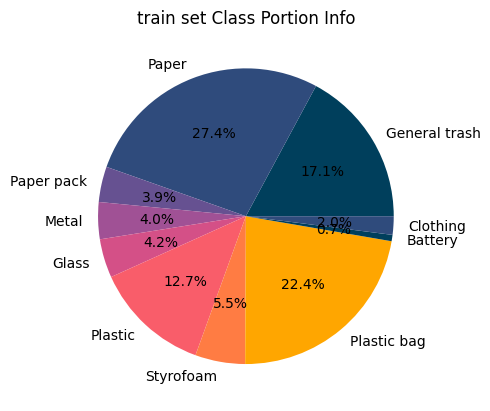

In [5]:
import matplotlib.pyplot as plt

# 데이터프레임에서 1행만 선택
row = portion.iloc[0]
values = [float(x.replace('%', '')) for x in row]

# 파이차트 그리기
# 컬러파레트생성기 https://www.learnui.design/tools/data-color-picker.html
color_palette = [
"#003f5c",
"#2f4b7c",
"#665191",
"#a05195",
"#d45087",
"#f95d6a",
"#ff7c43",
"#ffa600",
]
labels=row.index
#values, labels = zip(*sorted(zip(values, labels), reverse=True))
# 파이차트 그리기
plt.pie(values, labels=labels, colors = color_palette, autopct='%1.1f%%',)# startangle=90, counterclock=False)
plt.title("train set Class Portion Info")
#plt.legend(labels=labels, loc='upper right')
plt.show()

In [6]:
values, labels = zip(*sorted(zip(values, labels), reverse=True))
print(labels)
print(values)

('Paper', 'Plastic bag', 'General trash', 'Plastic', 'Styrofoam', 'Glass', 'Metal', 'Paper pack', 'Clothing', 'Battery')
(27.45, 22.37, 17.14, 12.72, 5.46, 4.24, 4.04, 3.88, 2.02, 0.69)


#### train, val json 만들기

In [7]:
print(train_idx)
print(groups[train_idx])

train_img_ids = set(groups[train_idx])
print(train_img_ids)

[    0     1     2 ... 23141 23142 23143]
[   0    1    1 ... 4882 4882 4882]
{0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 84, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 99, 100, 102, 103, 104, 105, 106, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 159, 160, 161, 163, 164, 165, 166, 169, 170, 171, 173, 174, 176, 177, 178, 179, 180, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 200, 201, 202, 203, 204, 206, 207, 208, 210, 211, 212, 213, 214, 216, 217, 218, 219, 221, 222, 223, 225, 226, 227, 229, 230, 231, 233, 234, 235, 236, 237, 238, 239, 241, 242, 243, 244, 245, 246, 

In [8]:
def save_coco(file, info, licenses, images, annotations, categories):
    with open(file, 'wt', encoding='UTF-8') as coco:
        json.dump({ 'info': info, 'licenses': licenses, 'images': images, 
            'annotations': annotations, 'categories': categories}, coco, indent=2, sort_keys=True)
        
coco = data
info = coco['info']
licenses = coco['licenses']
images = coco['images']
annotations = coco['annotations']
categories = coco['categories']

train_file_name = NEW_TRAIN_JSON_NAME
val_file_name = NEW_VAL_JSON_NAME

train_annotations = []
val_annotations = []
train_images = []
val_images = []

In [40]:
print(len(data['annotations']))

for ann in data['annotations'] :
    if ann['id'] in train_idx :
        train_annotations.append(ann)
    else :
        val_annotations.append(ann)

23144


In [41]:
print(len(data['images']))

for img in data['images'] :
    if img['id'] in train_img_ids :
        train_images.append(img)
    else :
        val_images.append(img)

4883


In [44]:
# 문제 없는지 한 번 더 체크
print(len(train_annotations))
print(len(val_annotations))
print(len(train_annotations) + len(val_annotations))

print(len(train_images))
print(len(val_images))
print(len(train_images) + len(val_images))


18783
4361
23144
3909
974
4883


In [42]:
save_coco(train_file_name, info, licenses, train_images, train_annotations, categories)
save_coco(val_file_name, info, licenses, val_images, val_annotations, categories)